CMIP6 Mean Precipitation: 4.0986215e-05
CMIP5 Mean Precipitation: 5.2455405e-05
T-test P-value: 2.3053558342772364e-67
Annual Increase in Precipitation (CMIP6): 2.7612539543402135e-08
Annual Increase in Precipitation (CMIP5): 1.775550977964989e-08


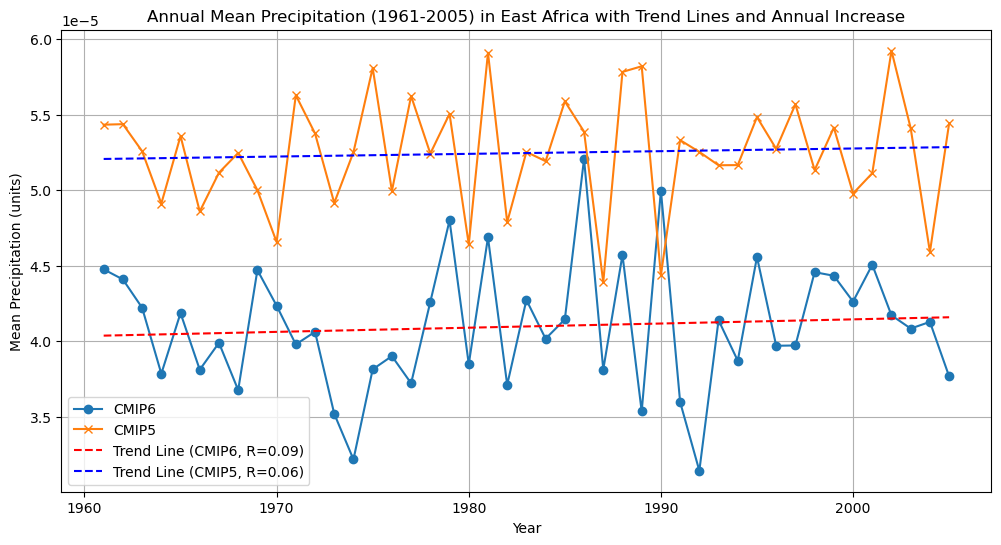

In [103]:
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import numpy as np
from scipy.stats import ttest_ind, linregress
import matplotlib.pyplot as plt

# CMIP6 dataset URL
cmip6_url = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/pr/gn/v20190429/pr_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc"

# CMIP5 dataset URL
cmip5_url = "http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg_dataroot/AR5/CMIP5/output/CCCma/CanCM4/historical/mon/atmos/pr/r1i1p1/pr_Amon_CanCM4_historical_r1i1p1_196101-200512.nc"

# Function to calculate annual mean precipitation and return flattened data
def calculate_annual_mean_and_flatten(dataset, start_year, end_year, lat_range, lon_range):
    """
    Calculate the annual mean precipitation for a specific period and region in a dataset and return both the annual mean and flattened data.

    This function first slices the dataset for a specified time period and geographical region. It then calculates the annual mean precipitation by averaging over latitude, longitude, and time. Additionally, it flattens the precipitation data to a 1D array for further statistical analysis.

    Parameters:
    dataset (xarray.Dataset): The dataset to process.
    start_year (str): The start year for the period of interest.
    end_year (str): The end year for the period of interest.
    lat_range (tuple): A tuple specifying the latitude range as (min_lat, max_lat).
    lon_range (tuple): A tuple specifying the longitude range as (min_lon, max_lon).

    Returns:
    tuple: A tuple containing two elements:
           - xarray.DataArray: The annual mean precipitation for each year in the specified period.
           - numpy.ndarray: Flattened 1D array of all precipitation data for statistical analysis.
    """
    period = dataset.sel(time=slice(start_year, end_year))
    region = period.sel(lat=slice(*lat_range), lon=slice(*lon_range))

    annual_mean = region['pr'].groupby('time.year').mean(dim=('lat', 'lon', 'time'))
    flattened_data = region['pr'].values.flatten()
    
    return annual_mean, flattened_data

# Load the datasets
cmip6_ds = xr.open_dataset(cmip6_url)  # CMIP6 dataset URL
cmip5_ds = xr.open_dataset(cmip5_url)  # CMIP5 dataset URL

# Parameters for the analysis
start_year = "1961"
end_year = "2005"
lat_range = (-6, 12)
lon_range = (28, 42)

# Calculate annual mean precipitation and flatten data
cmip6_annual_mean, cmip6_flat = calculate_annual_mean_and_flatten(cmip6_ds, start_year, end_year, lat_range, lon_range)
cmip5_annual_mean, cmip5_flat = calculate_annual_mean_and_flatten(cmip5_ds, start_year, end_year, lat_range, lon_range)

# Calculate overall mean precipitation
cmip6_mean_precip = np.mean(cmip6_flat)
cmip5_mean_precip = np.mean(cmip5_flat)

print("CMIP6 Mean Precipitation:", cmip6_mean_precip)
print("CMIP5 Mean Precipitation:", cmip5_mean_precip)

# Perform t-test
t_stat, p_val = ttest_ind(cmip6_flat, cmip5_flat, equal_var=False, nan_policy='omit')
print("T-test P-value:", p_val)

# Extracting years and values for plotting
years_cmip6 = cmip6_annual_mean['year'].values
mean_precip_cmip6 = cmip6_annual_mean.values

years_cmip5 = cmip5_annual_mean['year'].values
mean_precip_cmip5 = cmip5_annual_mean.values

# Calculate trend lines using linear regression
slope_cmip6, intercept_cmip6, r_value_cmip6, p_value_cmip6, std_err_cmip6 = linregress(years_cmip6, mean_precip_cmip6)
trend_line_cmip6 = slope_cmip6 * years_cmip6 + intercept_cmip6

slope_cmip5, intercept_cmip5, r_value_cmip5, p_value_cmip5, std_err_cmip5 = linregress(years_cmip5, mean_precip_cmip5)
trend_line_cmip5 = slope_cmip5 * years_cmip5 + intercept_cmip5

# Calculate annual increase/decrease
annual_increase_cmip6 = slope_cmip6
annual_increase_cmip5 = slope_cmip5

# Print the annual increase in precipitation
print("Annual Increase in Precipitation (CMIP6):", annual_increase_cmip6)
print("Annual Increase in Precipitation (CMIP5):", annual_increase_cmip5)

# Plotting with trend lines and annual increase
plt.figure(figsize=(12, 6))
plt.plot(years_cmip6, mean_precip_cmip6, label='CMIP6', marker='o')
plt.plot(years_cmip5, mean_precip_cmip5, label='CMIP5', marker='x')
plt.plot(years_cmip6, trend_line_cmip6, linestyle='--', label=f'Trend Line (CMIP6, R={r_value_cmip6:.2f})', color='red')
plt.plot(years_cmip5, trend_line_cmip5, linestyle='--', label=f'Trend Line (CMIP5, R={r_value_cmip5:.2f})', color='blue')

plt.title('Annual Mean Precipitation (1961-2005) in East Africa with Trend Lines and Annual Increase')
plt.xlabel('Year')
plt.ylabel('Mean Precipitation (units)')
plt.legend()
plt.grid(True) 
plt.show()



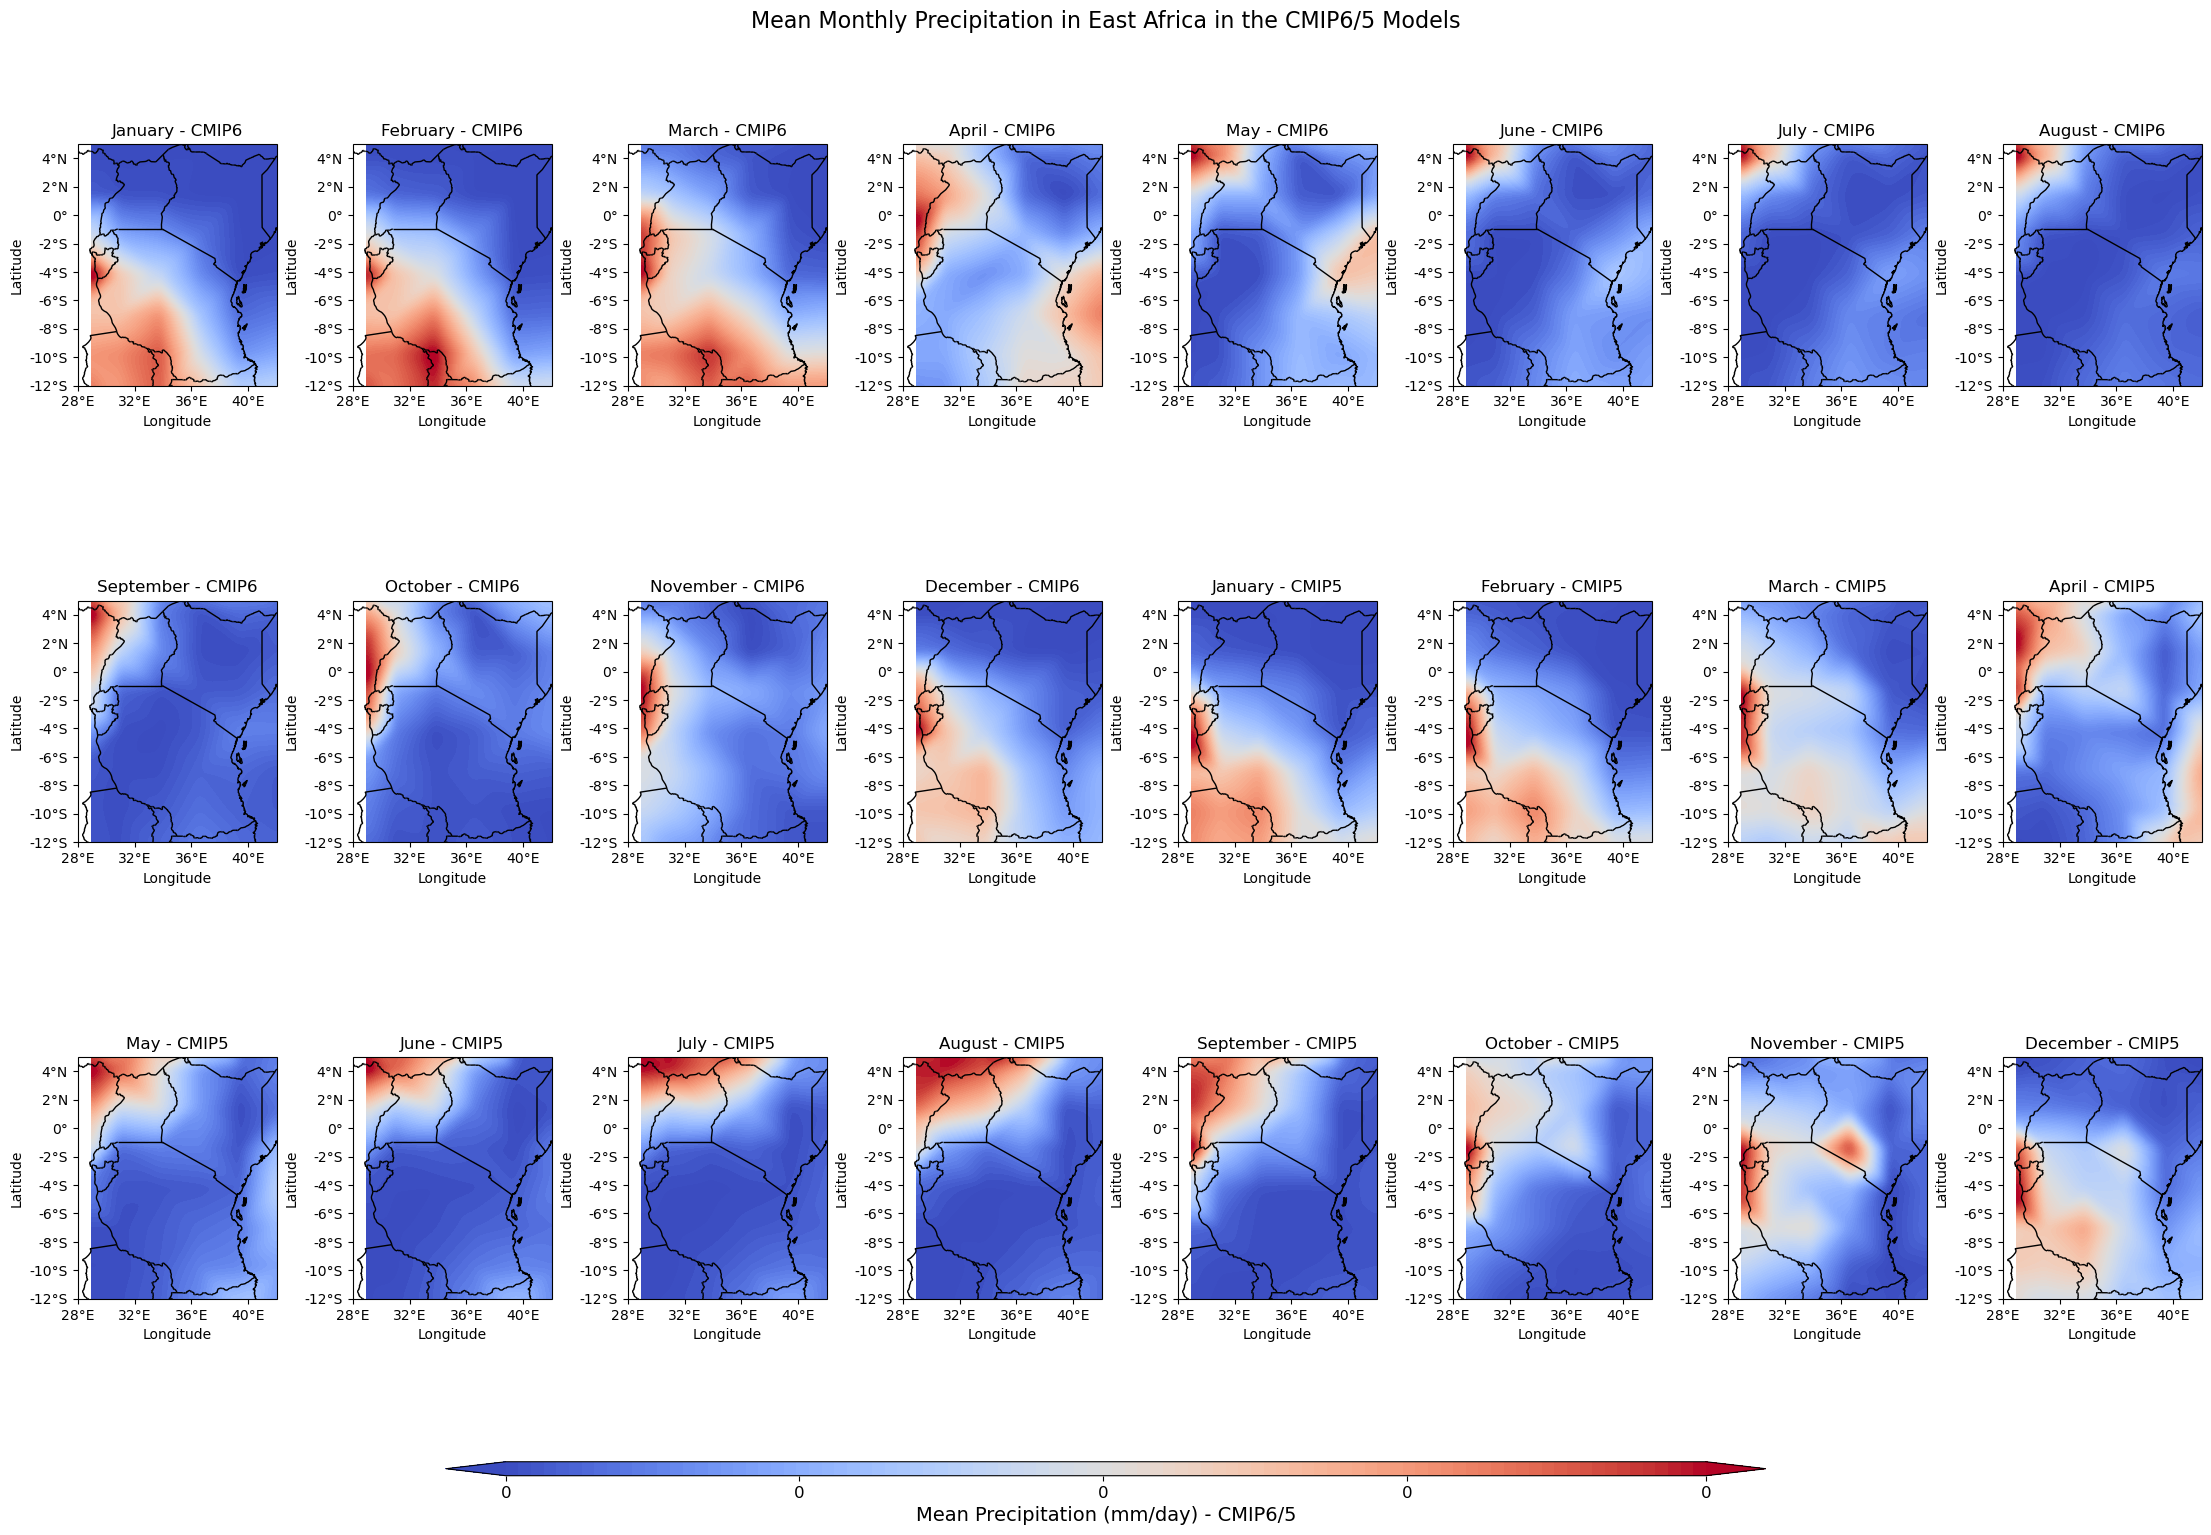

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.interpolate
from scipy.ndimage import gaussian_filter

# CMIP6 dataset URL
cmip6_url = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/pr/gn/v20190429/pr_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc"

# CMIP5 dataset URL
cmip5_url = "http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg_dataroot/AR5/CMIP5/output/CCCma/CanCM4/historical/mon/atmos/pr/r1i1p1/pr_Amon_CanCM4_historical_r1i1p1_196101-200512.nc"

# Open the CMIP6 dataset using xarray
cmip6_ds = xr.open_dataset(cmip6_url)

# Open the CMIP5 dataset using xarray
cmip5_ds = xr.open_dataset(cmip5_url)

# Define latitude and longitude grids for interpolation
lon_new = np.linspace(29, 42, 200)
lat_new = np.linspace(-12, 5, 200)

# Define month names for titles
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Define figure and axes for the subplots with constrained_layout
fig, axes = plt.subplots(3, 8, figsize=(22, 14), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
axes = axes.flatten()

# Loop through each month to create subplots for CMIP6 and CMIP5
for month in range(1, 13):
    ax = axes[month - 1]
    
    # Select monthly data for CMIP6 and CMIP5 and calculate monthly means
    cmip6_monthly_data = cmip6_ds['pr'].sel(time=cmip6_ds['time.month'] == month).mean(dim='time')
    cmip5_monthly_data = cmip5_ds['pr'].sel(time=cmip5_ds['time.month'] == month).mean(dim='time')

    # Create 2D mesh for original lon and lat for both models
    lon_cmip6, lat_cmip6 = np.meshgrid(cmip6_monthly_data['lon'], cmip6_monthly_data['lat'])
    lon_cmip5, lat_cmip5 = np.meshgrid(cmip5_monthly_data['lon'], cmip5_monthly_data['lat'])

    # Flatten and mask the data for both models
    pr_cmip6_flat = cmip6_monthly_data.values.flatten()
    mask_cmip6 = ~np.isnan(pr_cmip6_flat)
    lon_cmip6_valid = lon_cmip6.flatten()[mask_cmip6]
    lat_cmip6_valid = lat_cmip6.flatten()[mask_cmip6]
    pr_cmip6_valid = pr_cmip6_flat[mask_cmip6]

    pr_cmip5_flat = cmip5_monthly_data.values.flatten()
    mask_cmip5 = ~np.isnan(pr_cmip5_flat)
    lon_cmip5_valid = lon_cmip5.flatten()[mask_cmip5]
    lat_cmip5_valid = lat_cmip5.flatten()[mask_cmip5]
    pr_cmip5_valid = pr_cmip5_flat[mask_cmip5]

    # Create new grid for interpolation
    lon_grid_new, lat_grid_new = np.meshgrid(lon_new, lat_new)
    points_new = np.array([lon_grid_new.flatten(), lat_grid_new.flatten()]).T  # Reshape for griddata

    # Interpolate using linear method for both models
    interpolated_pr_cmip6 = scipy.interpolate.griddata(
        (lon_cmip6_valid, lat_cmip6_valid), pr_cmip6_valid, points_new, method='linear')

    interpolated_pr_cmip5 = scipy.interpolate.griddata(
        (lon_cmip5_valid, lat_cmip5_valid), pr_cmip5_valid, points_new, method='linear')

    # Reshape interpolated data back to 2D
    interpolated_pr_cmip6_2d = interpolated_pr_cmip6.reshape(lon_grid_new.shape)
    interpolated_pr_cmip5_2d = interpolated_pr_cmip5.reshape(lon_grid_new.shape)

    # Apply Gaussian smoothing for both models
    smoothed_pr_cmip6 = gaussian_filter(interpolated_pr_cmip6_2d, sigma=4)
    smoothed_pr_cmip5 = gaussian_filter(interpolated_pr_cmip5_2d, sigma=4)

    # Plotting with specified color range for CMIP6
    contour_cmip6 = ax.contourf(lon_grid_new, lat_grid_new, smoothed_pr_cmip6, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=100, extend='both')
    ax.set_title(f'{month_names[month]} - CMIP6')

    # Plotting with specified color range for CMIP5
    ax2 = axes[month + 11]
    contour_cmip5 = ax2.contourf(lon_grid_new, lat_grid_new, smoothed_pr_cmip5, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=100, extend='both')
    ax2.set_title(f'{month_names[month]} - CMIP5')

    # Set extent to the desired area for both subplots
    ax.set_extent([29, 42, -12, 5], crs=ccrs.PlateCarree())
    ax2.set_extent([29, 42, -12, 5], crs=ccrs.PlateCarree())

    # Adding coastlines and borders for both subplots
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS)

    # Customize labels and ticks for both subplots
    ax.set_xticks(np.arange(28, 43, 4), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-12, 6, 2), crs=ccrs.PlateCarree())  # Adjusted latitude ticks
    ax.xaxis.set_major_formatter(plt.FixedFormatter(['28°E', '32°E', '36°E', '40°E', '42°E']))
    ax.yaxis.set_major_formatter(plt.FixedFormatter(['-12°S', '-10°S', '-8°S', '-6°S', '-4°S', '-2°S', '0°', '2°N', '4°N']))  # Adjusted latitude labels

    ax2.set_xticks(np.arange(28, 43, 4), crs=ccrs.PlateCarree())
    ax2.set_yticks(np.arange(-12, 6, 2), crs=ccrs.PlateCarree())  # Adjusted latitude ticks
    ax2.xaxis.set_major_formatter(plt.FixedFormatter(['28°E', '32°E', '36°E', '40°E', '42°E']))
    ax2.yaxis.set_major_formatter(plt.FixedFormatter(['-12°S', '-10°S', '-8°S', '-6°S', '-4°S', '-2°S', '0°', '2°N', '4°N']))  # Adjusted latitude labels

    # Add labels for x-axis and y-axis for both subplots
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

# Create a new color bar for CMIP6
cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.01])  # Adjusted position and height
cbar_cmip6 = fig.colorbar(contour_cmip6, cax=cbar_ax, orientation='horizontal', ticks=np.linspace(smoothed_pr_cmip6.min(), smoothed_pr_cmip6.max(), 5))
cbar_cmip6.set_label('Mean Precipitation (mm/day) - CMIP6/5', fontsize=14)
cbar_cmip6.ax.set_xticklabels([f'{tick:.0f}' for tick in cbar_cmip6.get_ticks()], fontsize=12)



# Add a super title
fig.suptitle('Mean Monthly Precipitation in East Africa in the CMIP6/5 Models', fontsize=16)

plt.show()


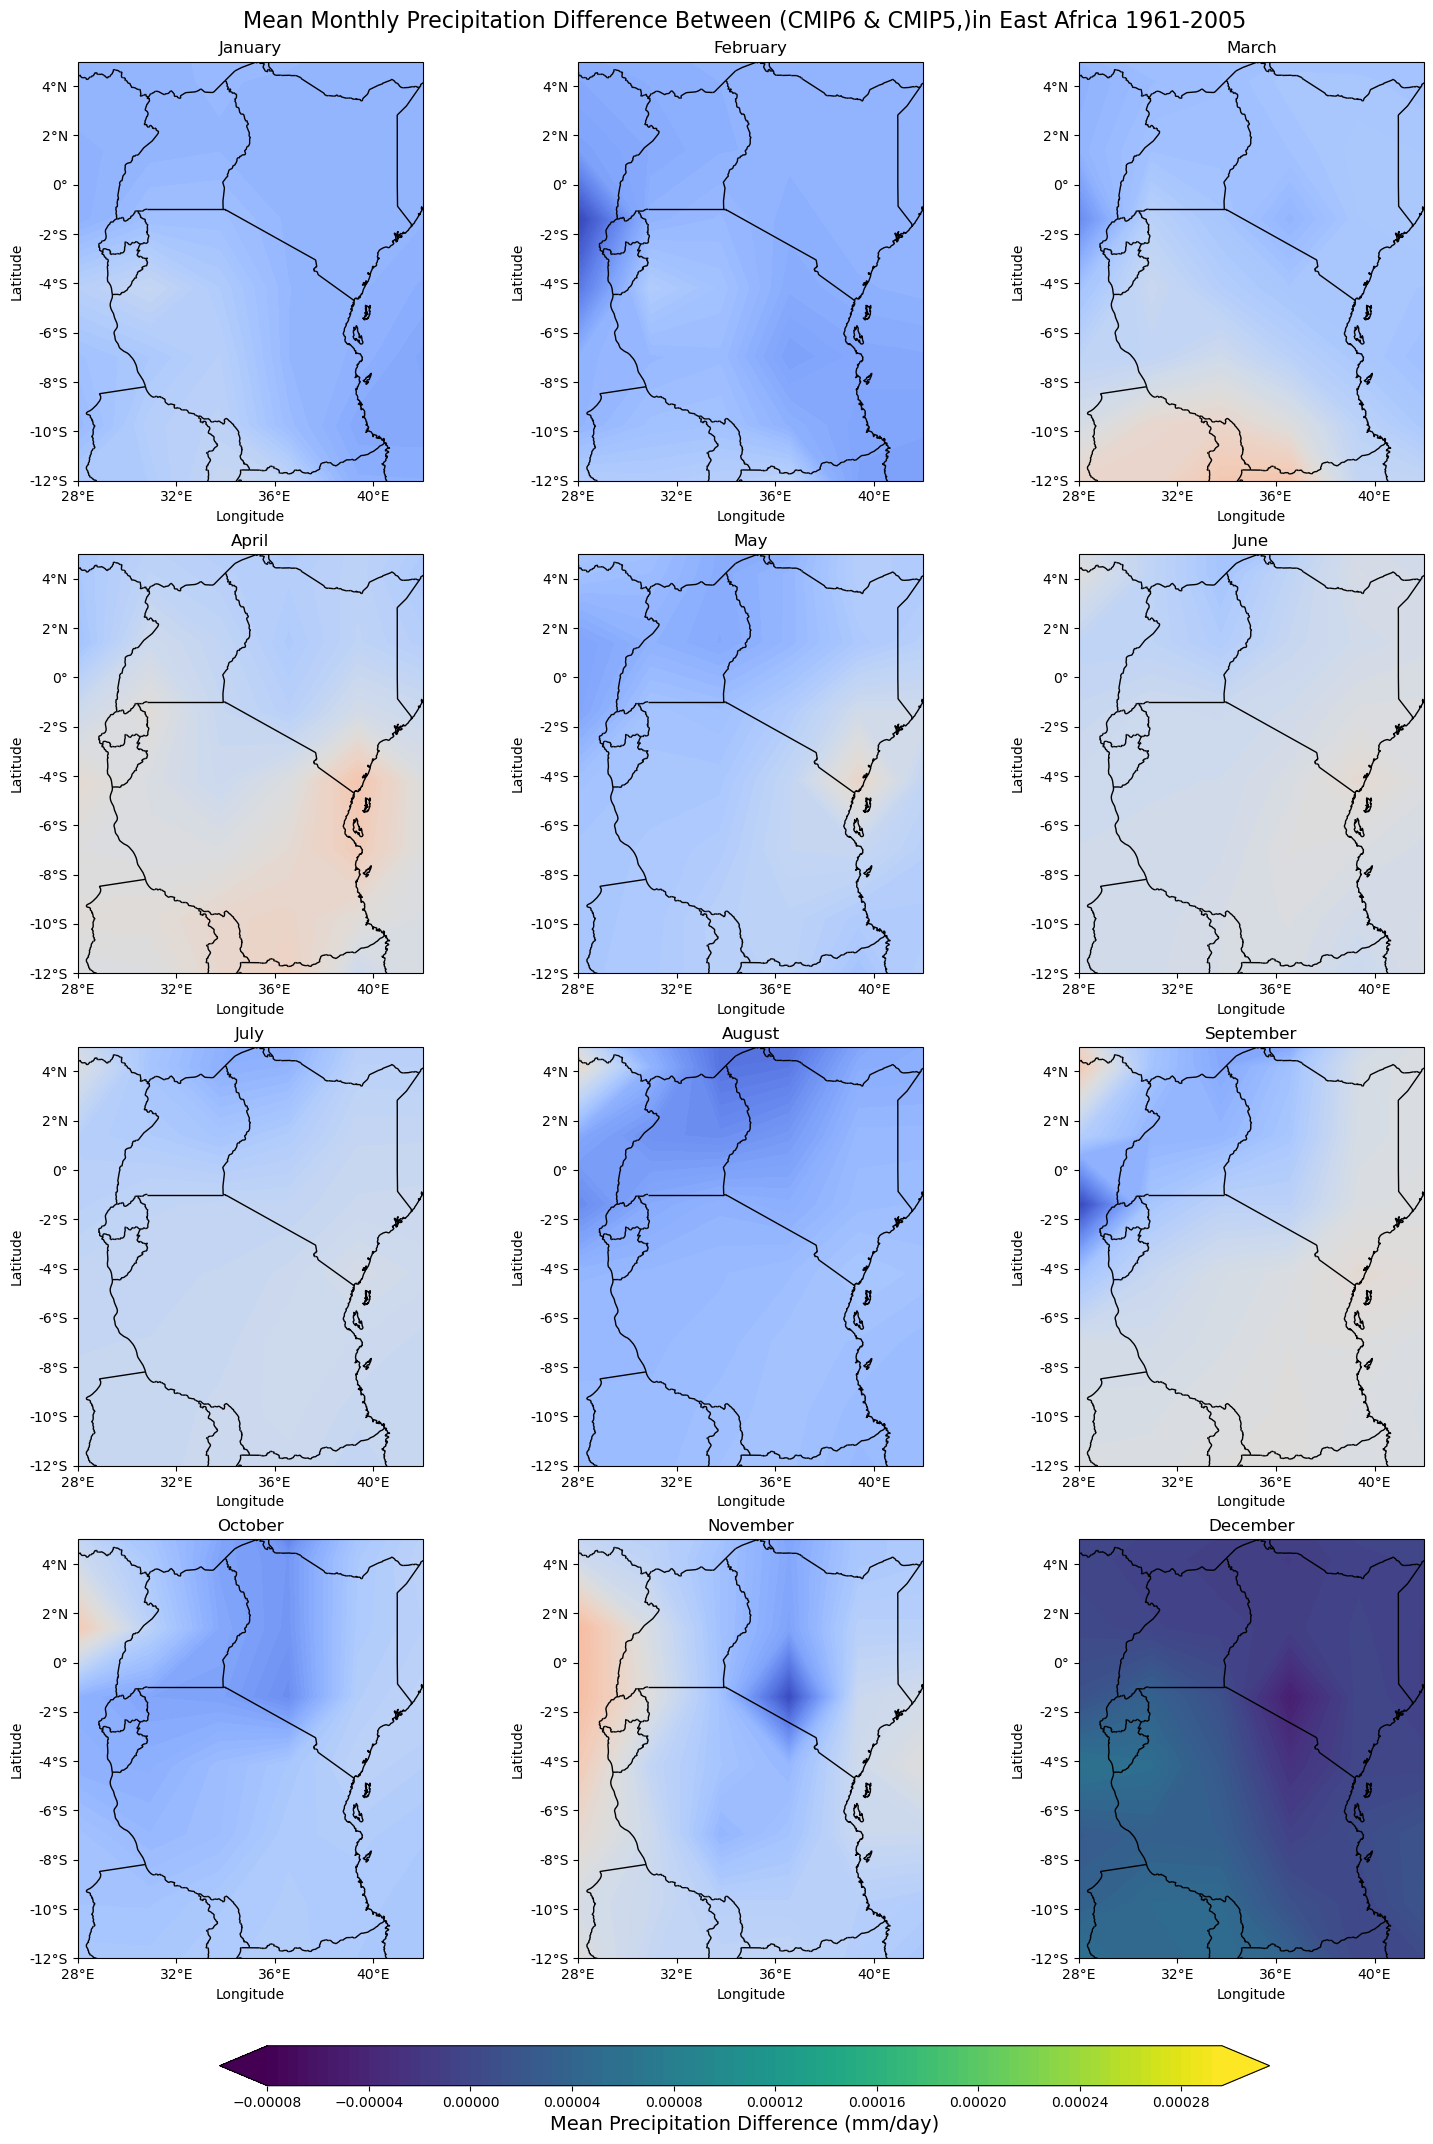

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings



# Suppress specific FutureWarnings from xarray
warnings.filterwarnings("ignore", category=FutureWarning, module="xarray")

# CMIP6 dataset URL
cmip6_url = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/pr/gn/v20190429/pr_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc"

# CMIP5 dataset URL
cmip5_url = "http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg_dataroot/AR5/CMIP5/output/CCCma/CanCM4/historical/mon/atmos/pr/r1i1p1/pr_Amon_CanCM4_historical_r1i1p1_196101-200512.nc"

# Open the CMIP6 dataset using xarray
cmip6_ds = xr.open_dataset(cmip6_url)

# Open the CMIP5 dataset using xarray
cmip5_ds = xr.open_dataset(cmip5_url)

# Select data within the study period 1961-2005
cmip6_ds = cmip6_ds.sel(time=slice('1961-01-01', '2005-12-31'))
cmip5_ds = cmip5_ds.sel(time=slice('1961-01-01', '2005-12-31'))

# Define month names for titles
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Function to interpolate dataset to a common grid
def interpolate_to_common_grid(source_ds, target_lon, target_lat):
    return source_ds.interp(lon=target_lon, lat=target_lat, method='nearest')



# Define figure for the subplots with a 4x3 layout
fig, axes = plt.subplots(4, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each month to create subplots for the difference
for month in range(1, 13):
    ax = axes[month - 1]

    # Select monthly data for CMIP6 and CMIP5 and calculate monthly means
    cmip6_monthly_data = cmip6_ds['pr'].sel(time=cmip6_ds['time.month'] == month).mean(dim='time')
    cmip5_monthly_data = cmip5_ds['pr'].sel(time=cmip5_ds['time.month'] == month).mean(dim='time')

    # Regrid CMIP5 data to match CMIP6 data
    cmip5_monthly_regridded = interpolate_to_common_grid(cmip5_monthly_data, cmip6_monthly_data['lon'], cmip6_monthly_data['lat'])

    # Calculate the difference in precipitation means
    diff_pr = cmip6_monthly_data - cmip5_monthly_regridded

    

    # Plotting for the difference
    ax.contourf(diff_pr.lon, diff_pr.lat, diff_pr, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=100, extend='both')
    ax.set_title(f'{month_names[month]}')  


    # Set extent, add coastlines, borders, and labels
    ax.set_extent([29, 42, -12, 5], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    
    
    # Customize labels and ticks for both subplots
    ax.set_xticks(np.arange(28, 43, 4), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-12, 6, 2), crs=ccrs.PlateCarree())  # Adjusted latitude ticks
    ax.xaxis.set_major_formatter(plt.FixedFormatter(['28°E', '32°E', '36°E', '40°E', '42°E']))
    ax.yaxis.set_major_formatter(plt.FixedFormatter(['-12°S', '-10°S', '-8°S', '-6°S', '-4°S', '-2°S', '0°', '2°N', '4°N']))  # Adjusted latitude labels


    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Create a common color bar for the difference plots
cbar_ax = fig.add_axes([0.15, -0.04, 0.7, 0.02])
cbar = fig.colorbar(ax.contourf(diff_pr.lon, diff_pr.lat, diff_pr, levels=100, extend='both'), cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean Precipitation Difference (mm/day)', fontsize=14)

# Add a super title
fig.suptitle('Mean Monthly Precipitation Difference Between (CMIP6 & CMIP5,)in East Africa 1961-2005', fontsize=16)

plt.show()


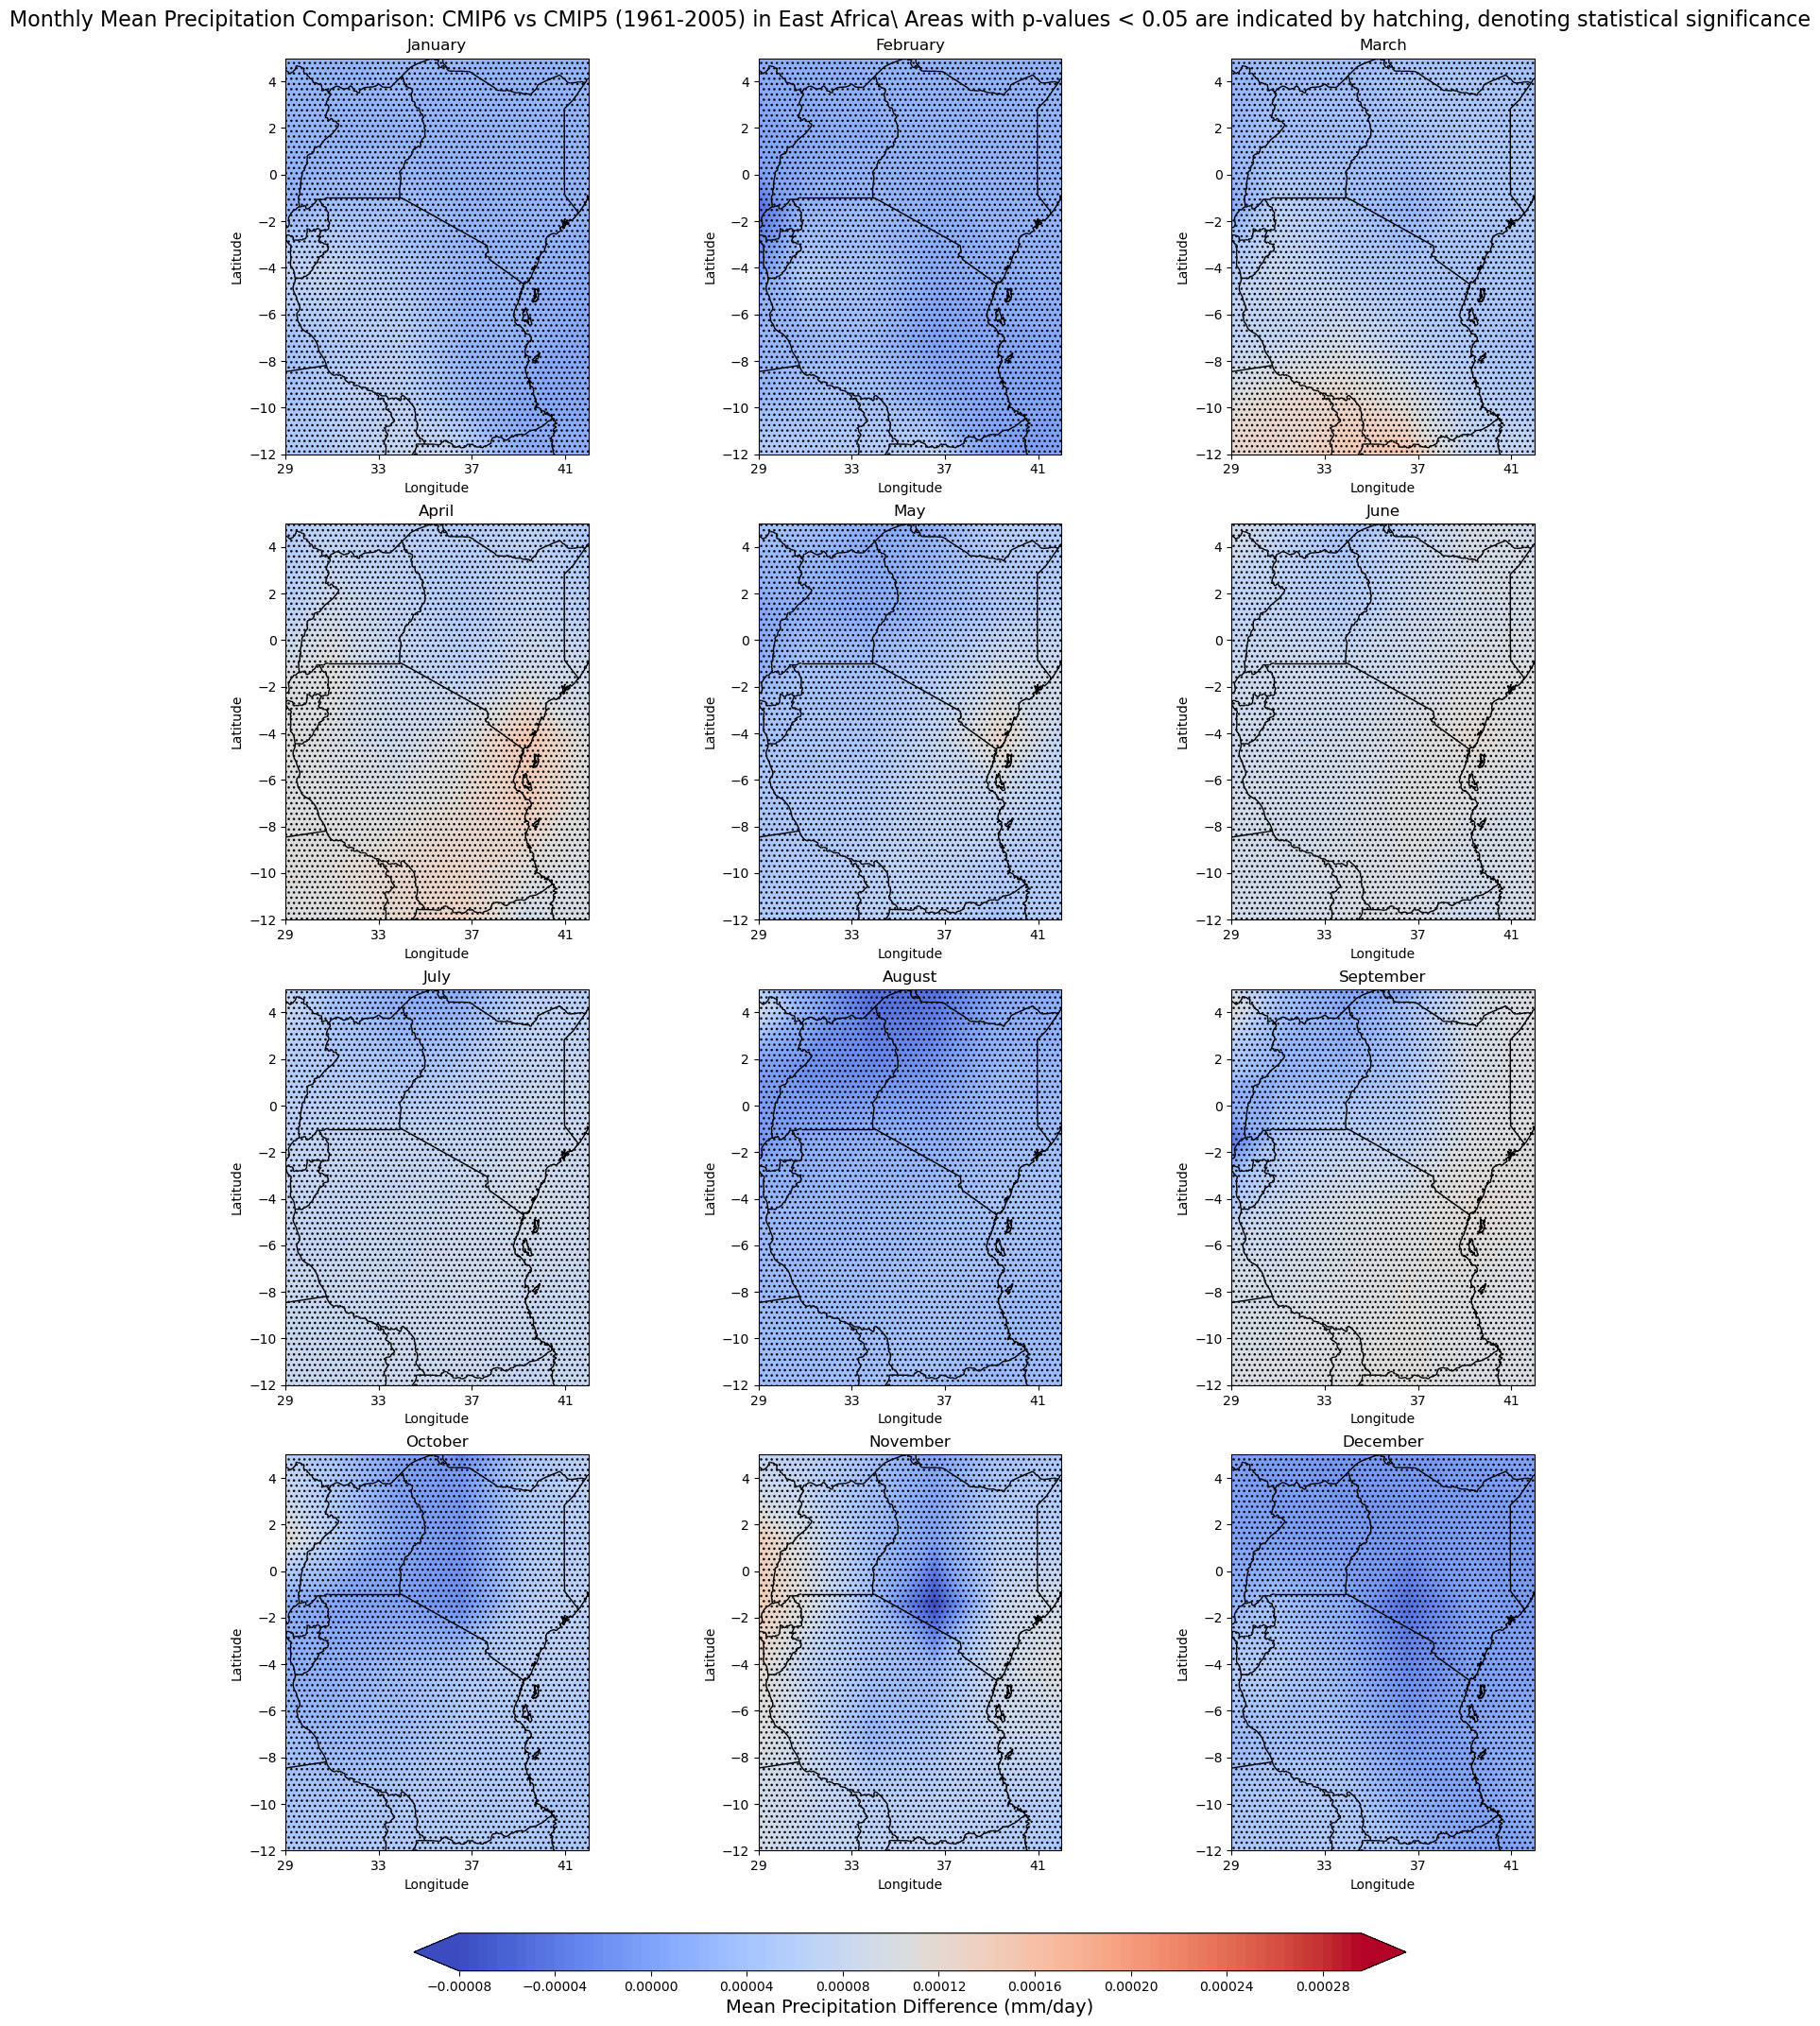

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from scipy.stats import ttest_ind

# Suppress specific FutureWarnings from xarray
warnings.filterwarnings("ignore", category=FutureWarning, module="xarray")

# CMIP6 dataset URL
cmip6_url = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/pr/gn/v20190429/pr_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc"

# CMIP5 dataset URL
cmip5_url = "http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg_dataroot/AR5/CMIP5/output/CCCma/CanCM4/historical/mon/atmos/pr/r1i1p1/pr_Amon_CanCM4_historical_r1i1p1_196101-200512.nc"

# Open the datasets
cmip6_ds = xr.open_dataset(cmip6_url)
cmip5_ds = xr.open_dataset(cmip5_url)

# Select data within the study period 1961-2005
cmip6_ds = cmip6_ds.sel(time=slice('1961-01-01', '2005-12-31'))
cmip5_ds = cmip5_ds.sel(time=slice('1961-01-01', '2005-12-31'))

# Define month names for titles
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Function to interpolate dataset to a common grid
def interpolate_to_common_grid(source_ds, target_lon, target_lat):
    return source_ds.interp(lon=target_lon, lat=target_lat, method='nearest')

# Define figure for the subplots with a 4x3 layout
fig, axes = plt.subplots(4, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each month to create subplots for the difference
for month in range(1, 13):
    ax = axes[month - 1]

    # Select monthly data and calculate monthly means
    cmip6_monthly_data = cmip6_ds['pr'].sel(time=cmip6_ds['time.month'] == month).mean(dim='time')
    cmip5_monthly_data = cmip5_ds['pr'].sel(time=cmip5_ds['time.month'] == month).mean(dim='time')

    # Regrid CMIP5 data to match CMIP6 data
    cmip5_monthly_regridded = interpolate_to_common_grid(cmip5_monthly_data, cmip6_monthly_data['lon'], cmip6_monthly_data['lat'])

    # Calculate the difference in precipitation means
    diff_pr = cmip6_monthly_data - cmip5_monthly_regridded

    # Perform t-test
    t_stat, p_value = ttest_ind(cmip6_monthly_data.values.flatten(), cmip5_monthly_regridded.values.flatten(), nan_policy='omit')

    # Plotting for the difference
    diff_plot = ax.contourf(diff_pr.lon, diff_pr.lat, diff_pr, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=100, extend='both')

    # Indicate areas of statistical significance
    significance_mask = np.full_like(diff_pr, False, dtype=bool)
    significance_mask[np.where(p_value < 0.05)] = True
    ax.contourf(diff_pr.lon, diff_pr.lat, significance_mask, transform=ccrs.PlateCarree(), colors='none', hatches=['...'], levels=[0, 1], alpha=0)

    ax.set_title(f'{month_names[month]}')

    # Set extent, add coastlines, borders, and labels
    ax.set_extent([29, 42, -12, 5], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_xticks(np.arange(29, 43, 4), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-12, 6, 2), crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Create a common color bar for the difference plots
cbar_ax = fig.add_axes([0.15, -0.04, 0.7, 0.02])
cbar = fig.colorbar(diff_plot, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean Precipitation Difference (mm/day)', fontsize=14)


# Add a super title
fig.suptitle('Monthly Mean Precipitation Comparison: CMIP6 vs CMIP5 (1961-2005) in East Africa\ Areas with p-values < 0.05 are indicated by hatching, denoting statistical significance', fontsize=16)


plt.show()


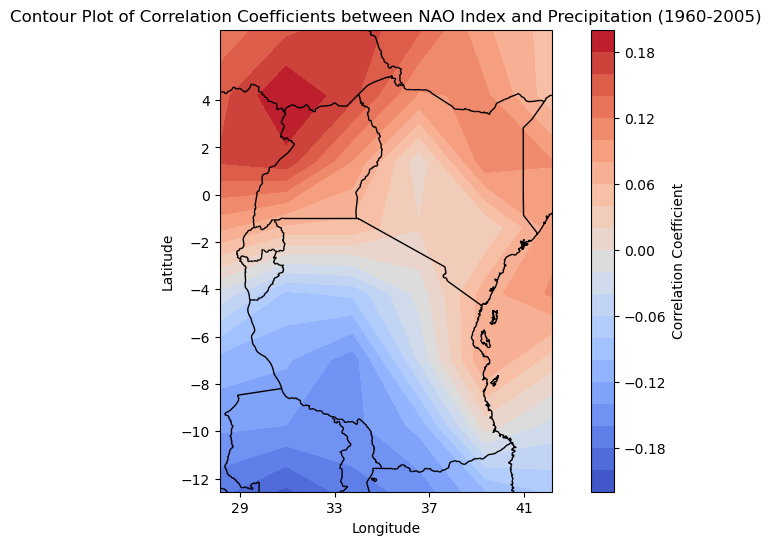

In [91]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from scipy.stats import pearsonr
import warnings

# Path to the NAO index data
nao_data_path = '/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
nao_data_file = 'nao.data'

# Load the NAO index data
df = pd.read_table(
    nao_data_path + nao_data_file,
    skiprows=1,
    header=None,
    delim_whitespace=True,
    index_col=0,
    parse_dates=True,
    na_values=['-99.9', '-99.90']
)
df.drop(df.tail(3).index, inplace=True)
start_date = str(df.index[0]) + '-' + str(df.columns[0]) + '-01'
end_date = str(df.index[-1]) + '-' + str(df.columns[-1]) + '-01'

# Create a date range for the NAO index
dates = pd.date_range(start=start_date, end=end_date, freq='MS')

# Reshape the NAO index data
clim_index = df.T.unstack().values
clim_index = clim_index.astype('float32')

# Create an xarray dataset for the NAO index
ds_index = xr.DataArray(
    clim_index,
    coords={'time': dates},
    dims=['time']
).to_dataset(name='nao')

# Define the CMIP6 precipitation data URL
cmip6_url = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/pr/gn/v20190429/pr_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc"

# Load CMIP6 precipitation data and convert to Pandas DataFrame
pr_dataset = xr.open_dataset(cmip6_url)
# Slice the latitude and longitude ranges using integer-based indexing
pr_data = pr_dataset.pr.sel(
    time=slice('1960-01-01', '2005-12-31'),
    lat=slice(-10, 15),
    lon=slice(28, 48)
).values
lats = pr_dataset.lat.sel(lat=slice(-13, 7)).values
lons = pr_dataset.lon.sel(lon=slice(26, 44)).values


# Iterate over each grid point and calculate the correlation
correlation_values = []

for lat_index, lat in enumerate(lats):
    for lon_index, lon in enumerate(lons):
        # Filter precipitation data for the current grid point
        pr_gridpoint = pr_data[:, lat_index, lon_index]

        # Filter NAO data for the same period
        nao_data = ds_index.sel(time=slice('1960-01-01', '2005-12-31'))['nao'].values

        # Calculate the correlation coefficient
        correlation, _ = pearsonr(pr_gridpoint, nao_data)
        correlation_values.append(correlation)

# Reshape correlation values into a grid
correlation_grid = np.array(correlation_values).reshape(len(lats), len(lons))


# Create a contour plot of correlation coefficients
plt.figure(figsize=(10, 6))

# Create a GeoAxes with PlateCarree projection

ax = plt.axes(projection=ccrs.PlateCarree())
# Add coastlines, borders, and labels
ax.coastlines(resolution='10m', linewidth=1, color='black')
ax.add_feature(cfeature.BORDERS, linewidth=1, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.set_xticks(np.arange(29, 43, 4), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-12, 6, 2), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

    

contour = plt.contourf(lons, lats, correlation_grid, levels=20, cmap='coolwarm')
plt.colorbar(contour, label='Correlation Coefficient')
plt.title('Contour Plot of Correlation Coefficients between NAO Index and Precipitation (1960-2005)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



Year 1960: Correlation Coefficient = -0.12
Year 1961: Correlation Coefficient = -0.66
Year 1962: Correlation Coefficient = -0.11
Year 1963: Correlation Coefficient = -0.46
Year 1964: Correlation Coefficient = -0.41
Year 1965: Correlation Coefficient = -0.36
Year 1966: Correlation Coefficient = -0.25
Year 1967: Correlation Coefficient = -0.42
Year 1968: Correlation Coefficient = -0.24
Year 1969: Correlation Coefficient = -0.38
Year 1970: Correlation Coefficient = -0.76
Year 1971: Correlation Coefficient = -0.32
Year 1972: Correlation Coefficient = -0.47
Year 1973: Correlation Coefficient = -0.43
Year 1974: Correlation Coefficient = 0.07
Year 1975: Correlation Coefficient = -0.14
Year 1976: Correlation Coefficient = -0.40
Year 1977: Correlation Coefficient = -0.13
Year 1978: Correlation Coefficient = -0.01
Year 1979: Correlation Coefficient = -0.20
Year 1980: Correlation Coefficient = 0.18
Year 1981: Correlation Coefficient = -0.15
Year 1982: Correlation Coefficient = 0.14
Year 1983: Cor

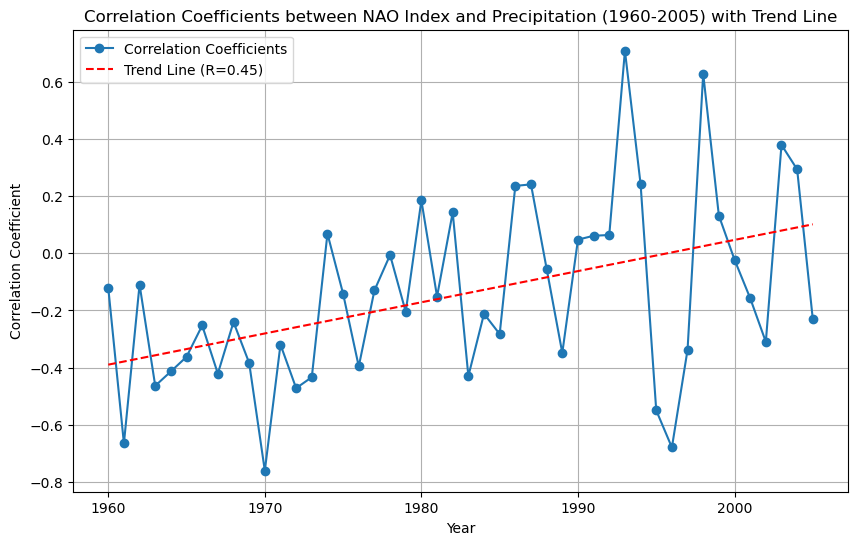

In [97]:
import pandas as pd
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, linregress  # Import linregress from scipy.stats
import matplotlib.pyplot as plt

# Path to the NAO index data
nao_data_path = '/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
nao_data_file = 'nao.data'

# Load the NAO index data
df = pd.read_table(
    nao_data_path + nao_data_file,
    skiprows=1,
    header=None,
    delim_whitespace=True,
    index_col=0,
    parse_dates=True,
    na_values=['-99.9', '-99.90']
)
df.drop(df.tail(3).index, inplace=True)
start_date = str(df.index[0]) + '-' + str(df.columns[0]) + '-01'
end_date = str(df.index[-1]) + '-' + str(df.columns[-1]) + '-01'

# Create a date range for the NAO index
dates = pd.date_range(start=start_date, end=end_date, freq='MS')

# Reshape the NAO index data
clim_index = df.T.unstack().values
clim_index = clim_index.astype('float32')

# Create an xarray dataset for the NAO index
ds_index = xr.DataArray(
    clim_index,
    coords={'time': dates},
    dims=['time']
).to_dataset(name='nao')

# Define the CMIP6 precipitation data URL
cmip6_url = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/pr/gn/v20190429/pr_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc"

# Load CMIP6 precipitation data and convert to Pandas DataFrame
pr_dataset = xr.open_dataset(cmip6_url)
# Slice the latitude and longitude ranges
pr_time_series = pr_dataset.pr.sel(time=slice('1960-01-01', '2005-12-31'), lat=slice(-13, 7), lon=slice(26, 42)).mean(dim=['lat', 'lon'])
pr_df = pr_time_series.to_dataframe().reset_index()
pr_df['time'] = pd.to_datetime(pr_df['time'].astype(str))

# Iterate over each year and calculate the correlation
years = range(1960, 2006)
correlation_values = []

for year in years:
    # Filter precipitation data for the current year
    pr_data = pr_df[(pr_df['time'].dt.year == year)]['pr'].values

    # Filter NAO data for the same year
    nao_data = ds_index.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))['nao'].values

    # Calculate the correlation coefficient
    correlation, _ = pearsonr(pr_data, nao_data)
    correlation_values.append(correlation)
    
# Calculate the mean correlation coefficient
mean_correlation = np.mean(correlation_values)

# Print the statistics for each year
for year, corr in zip(years, correlation_values):
    print(f"Year {year}: Correlation Coefficient = {corr:.2f}")

# Print the mean correlation coefficient
print(f"Mean Correlation Coefficient (1960-2005): {mean_correlation:.2f}")

# Calculate the trend line using linear regression
slope, intercept, r_value, p_value, std_err = linregress(years, correlation_values)

# Calculate the predicted values using the linear regression equation
trend_line = slope * np.array(years) + intercept

# Print the trend line equation
print(f"Trend Line Equation: y = {slope:.2f}x + {intercept:.2f}")

# Create a plot of correlation coefficients over the years with the trend line
plt.figure(figsize=(10, 6))
plt.plot(years, correlation_values, marker='o', linestyle='-', label='Correlation Coefficients')
plt.plot(years, trend_line, linestyle='--', label=f'Trend Line (R={r_value:.2f})', color='red')
plt.title('Correlation Coefficients between NAO Index and Precipitation (1960-2005) with Trend Line')
plt.xlabel('Year')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True)
plt.show()
